In this notebook, we will compare the performance of the current best FM found by exploration in muzero, against the custom one implemented in sQUlearn. 

The first dataset is the QFMNIST dataset, with 4 components and category 2,0 without the Ising layer!
We will use 100 training and 100 testing points

First important note: should we use QKRR, QSVR or QGPR?

In [1]:
from games.generate_quantum_data import create_quantum_fmnist

num_components = 4
category_filter_list = [2,0]
num_training, num_test = 100, 100
X_train,Y_train,X_test,Y_test = create_quantum_fmnist(
    num_training, num_test, num_components=num_components,category_filter_list=category_filter_list, num_su2_layers=0, su2_random_seed=42)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from squlearn.feature_map.layered_feature_map import LayeredFeatureMap
from qiskit.primitives import Estimator
from squlearn.kernel.matrix import ProjectedQuantumKernel, FidelityKernel
from squlearn.util import Executor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import RBF
from squlearn.kernel.ml import QKRR, QSVR

TRAINING SCORE AT START: 0.99450921698707
TEST SCORE AT START: 0.49790589131207175
TRAINING MSE AT START: 0.0008911782751034855
TEST MSE AT START: 0.08669719456298502


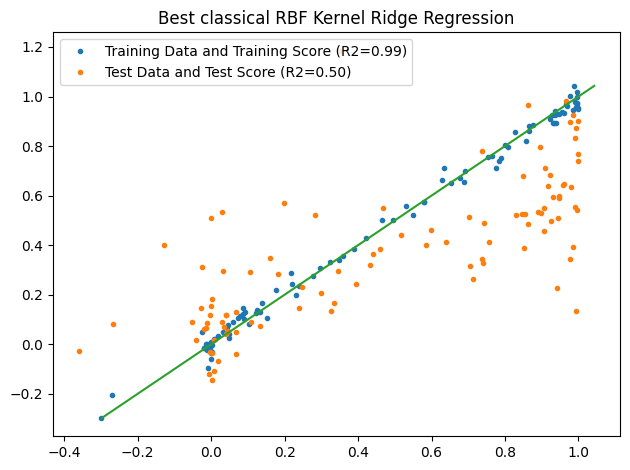

In [3]:
krr = KernelRidge(alpha=1e-2,kernel="rbf",gamma=0.36)
krr.fit(X_train,Y_train)

Y1 = krr.predict(X_train)
Y2 = krr.predict(X_test)
training_score = krr.score(X_train,Y_train)
test_score = krr.score(X_test,Y_test)
print("TRAINING SCORE AT START:",training_score)
print("TEST SCORE AT START:",test_score)
print("TRAINING MSE AT START:",mean_squared_error(Y_train,Y1))
print("TEST MSE AT START:",mean_squared_error(Y_test,Y2))
plt.figure()
plt.title("Best classical RBF Kernel Ridge Regression")
plt.plot(Y_train,Y1,'.', label=f"Training Data and Training Score (R2={training_score:.2f})")
plt.plot(Y_test,Y2,'.', label=f"Test Data and Test Score (R2={test_score:.2f})")
plt.plot([np.min(Y1),np.max(Y1)],[np.min(Y1),np.max(Y1)])
plt.legend(loc="upper left")
plt.tight_layout()


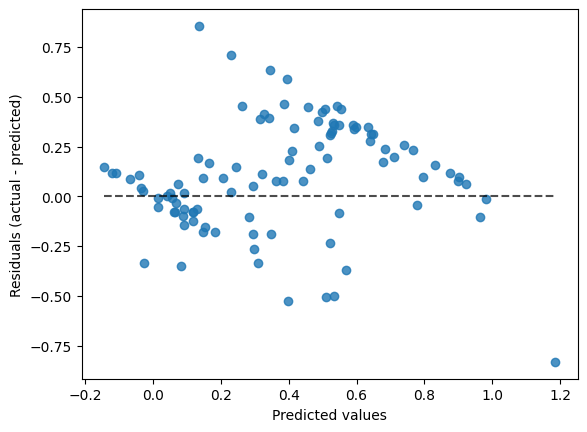

In [4]:
from sklearn.metrics import PredictionErrorDisplay
disp = PredictionErrorDisplay.from_predictions(y_true=Y_test, y_pred=Y2)
plt.show()

TRAINING SCORE AT START: 0.9981898165300657
TEST SCORE AT START: 0.9155836201015958


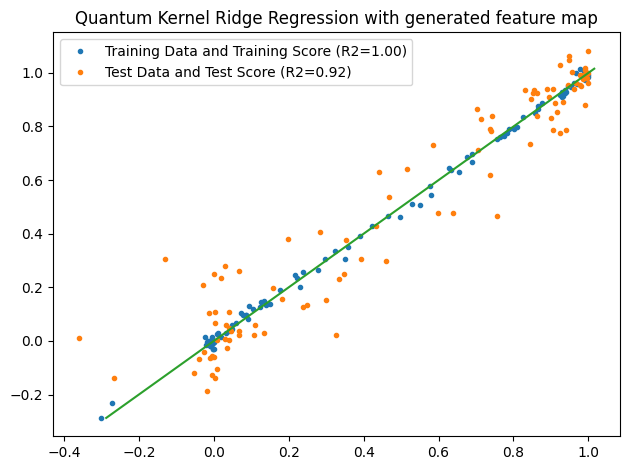

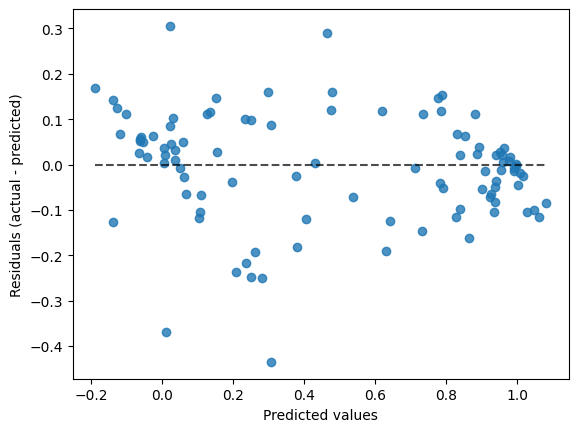

In [5]:
lfm = LayeredFeatureMap.from_string('Rx(p;=0*p+1/3*np.pi,{p})-crz(p;=0*p+4/3*np.pi,{p})-crx(p;=0*p+5/3*np.pi,{p})--Z-Rz(x;=(x),{x})-crx(p;=0*p+5/3*np.pi,{p})-Rx(p;=0*p+1/3*np.pi,{p})-Rx(x;=(x),{x})-Rx(x;=(x),{x})',num_qubits=4,num_features=4)
np.random.seed(42)
param_ini = np.random.uniform(-1,1,lfm.num_parameters)

quantum_kernel = ProjectedQuantumKernel(lfm,Executor("statevector_simulator"),initial_parameters=param_ini, gamma=0.36)
q_krr = QKRR(quantum_kernel=quantum_kernel, alpha=0.01)
q_krr.fit(X_train,Y_train)

Y1_qml = q_krr.predict(X_train)
Y2_qml = q_krr.predict(X_test)

training_score_qml = q_krr.score(X_train,Y_train)
test_score_qml = q_krr.score(X_test,Y_test)
print("TRAINING SCORE AT START:",q_krr.score(X_train,Y_train))
print("TEST SCORE AT START:",q_krr.score(X_test,Y_test))
plt.figure()
plt.title("Quantum Kernel Ridge Regression with generated feature map")
plt.plot(Y_train,Y1_qml,'.', label=f"Training Data and Training Score (R2={training_score_qml:.2f})")
plt.plot(Y_test,Y2_qml,'.', label=f"Test Data and Test Score (R2={test_score_qml:.2f})")
plt.plot([np.min(Y1_qml),np.max(Y1_qml)],[np.min(Y1_qml),np.max(Y1_qml)])
plt.legend(loc="upper left")
plt.tight_layout()
disp = PredictionErrorDisplay.from_predictions(y_true=Y_test, y_pred=Y2_qml)
plt.show()

num parameters: 17


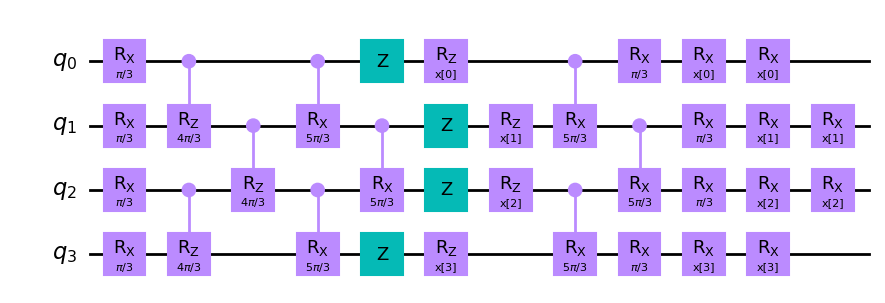

In [6]:
print('num parameters:', lfm.num_parameters)
lfm.draw(output="mpl")

In [7]:
from squlearn.feature_map import QEKFeatureMap, ChebPQC, YZ_CX_FeatureMap, HZCRxCRyCRz

In [8]:
qek_map = QEKFeatureMap(num_qubits=4, num_features=4, num_layers=2)
yz_cx = YZ_CX_FeatureMap(num_qubits=4, num_features=4, num_layers=2)
hzcrx = HZCRxCRyCRz(num_qubits=4, num_features=4, num_layers=1)
cheb_pqc = ChebPQC(num_qubits=4, num_features=4, num_layers=2)


In [9]:
print('num parameters qek:', qek_map.num_parameters)
print('num parameters yz_cx:', yz_cx.num_parameters)
print('num parameters hzcrx:', hzcrx.num_parameters)
print('num parameters cheb_pqc:', cheb_pqc.num_parameters)

num parameters qek: 16
num parameters yz_cx: 16
num parameters hzcrx: 12
num parameters cheb_pqc: 24


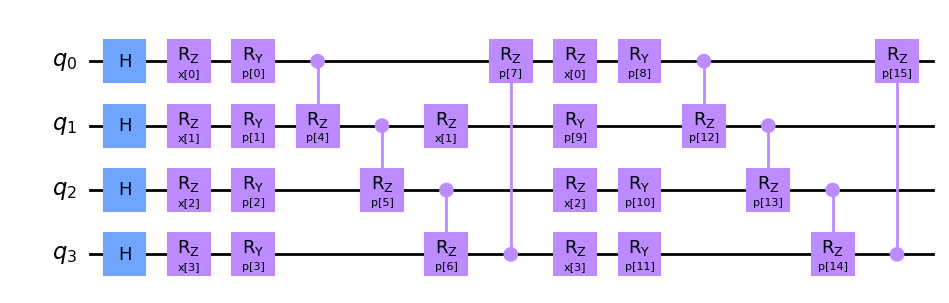

In [10]:
qek_map.draw(output="mpl")

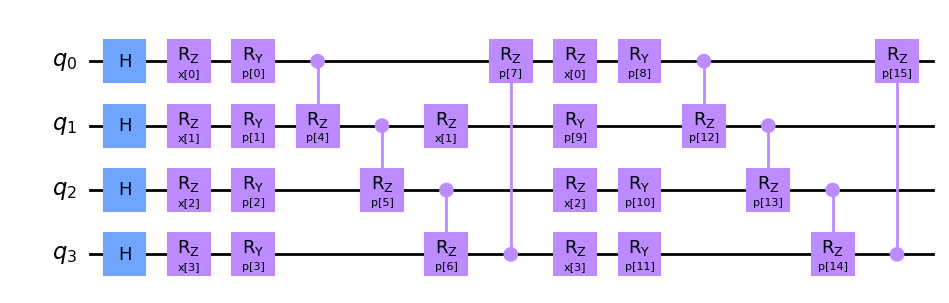

In [11]:
qek_map.draw(output="mpl")

TRAINING SCORE AT START: 0.9974388397311289
TEST SCORE AT START: 0.8598009208911565


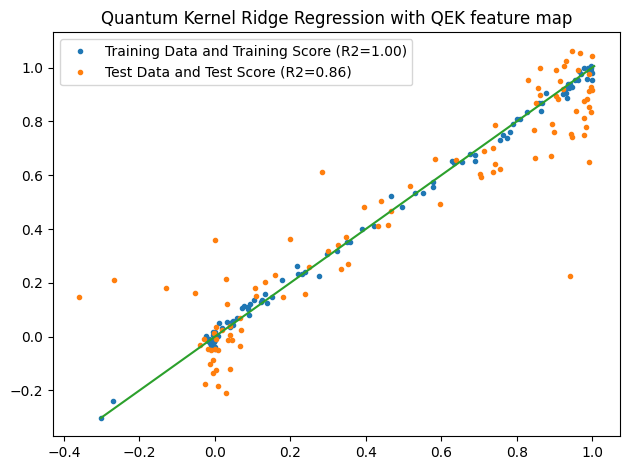

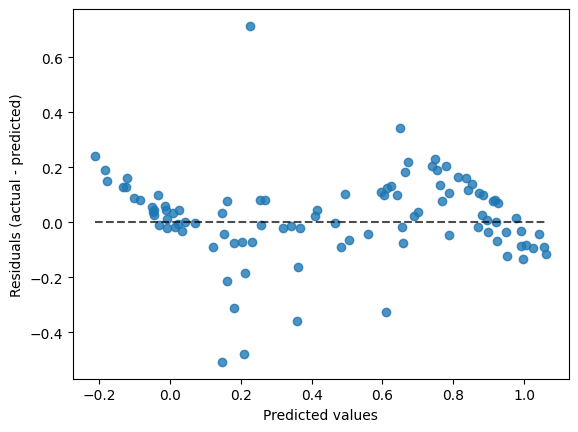

In [34]:
qek_kernel = ProjectedQuantumKernel(qek_map,Executor("statevector_simulator"),parameter_seed=0, gamma=0.8)
qek_krr = QKRR(quantum_kernel=qek_kernel, alpha=0.01)
qek_krr.fit(X_train,Y_train)

Y1_qek = qek_krr.predict(X_train)
Y2_qek = qek_krr.predict(X_test)

training_score_qek = qek_krr.score(X_train,Y_train)
test_score_qek = qek_krr.score(X_test,Y_test)
print("TRAINING SCORE AT START:",qek_krr.score(X_train,Y_train))
print("TEST SCORE AT START:",qek_krr.score(X_test,Y_test))
plt.figure()
plt.title("Quantum Kernel Ridge Regression with QEK feature map")
plt.plot(Y_train,Y1_qek,'.', label=f"Training Data and Training Score (R2={training_score_qek:.2f})")
plt.plot(Y_test,Y2_qek,'.', label=f"Test Data and Test Score (R2={test_score_qek:.2f})")
plt.plot([np.min(Y1_qek),np.max(Y1_qek)],[np.min(Y1_qek),np.max(Y1_qek)])
plt.legend(loc="upper left")
plt.tight_layout()
disp = PredictionErrorDisplay.from_predictions(y_true=Y_test, y_pred=Y2_qek)
plt.show()


TRAINING SCORE AT START: 0.9538653163384806
TEST SCORE AT START: 0.6033804267625233


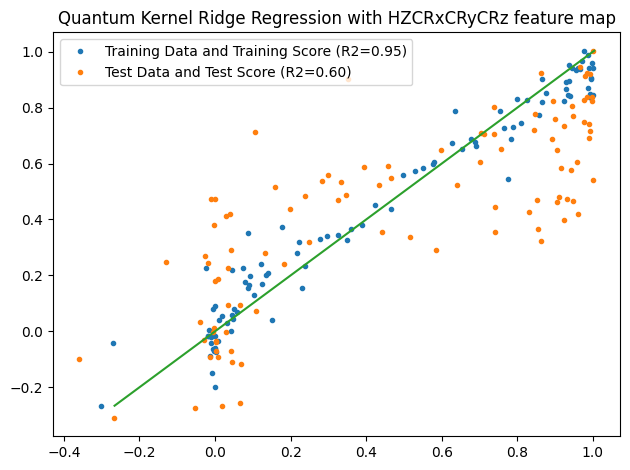

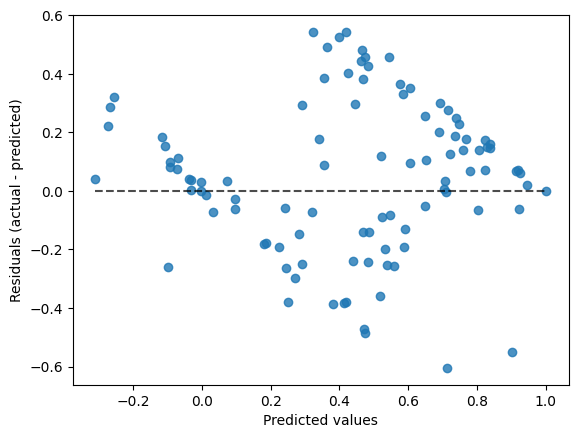

In [41]:
hzcrx_kernel = ProjectedQuantumKernel(hzcrx,Executor("statevector_simulator"),parameter_seed=0, gamma=0.4)
hzcrx_krr = QKRR(quantum_kernel=hzcrx_kernel, alpha=0.01)
hzcrx_krr.fit(X_train,Y_train)

Y1_hzcrx = hzcrx_krr.predict(X_train)
Y2_hzcrx = hzcrx_krr.predict(X_test)

training_score_hzcrx = hzcrx_krr.score(X_train,Y_train)
test_score_hzcrx = hzcrx_krr.score(X_test,Y_test)
print("TRAINING SCORE AT START:",hzcrx_krr.score(X_train,Y_train))
print("TEST SCORE AT START:",hzcrx_krr.score(X_test,Y_test))
plt.figure()
plt.title("Quantum Kernel Ridge Regression with HZCRxCRyCRz feature map")
plt.plot(Y_train,Y1_hzcrx,'.', label=f"Training Data and Training Score (R2={training_score_hzcrx:.2f})")
plt.plot(Y_test,Y2_hzcrx,'.', label=f"Test Data and Test Score (R2={test_score_hzcrx:.2f})")
plt.plot([np.min(Y1_hzcrx),np.max(Y1_hzcrx)],[np.min(Y1_hzcrx),np.max(Y1_hzcrx)])
plt.legend(loc="upper left")
plt.tight_layout()
disp = PredictionErrorDisplay.from_predictions(y_true=Y_test, y_pred=Y2_hzcrx)
plt.show()


TRAINING SCORE AT START: 0.9870083673347387
TEST SCORE AT START: 0.5551569201185963


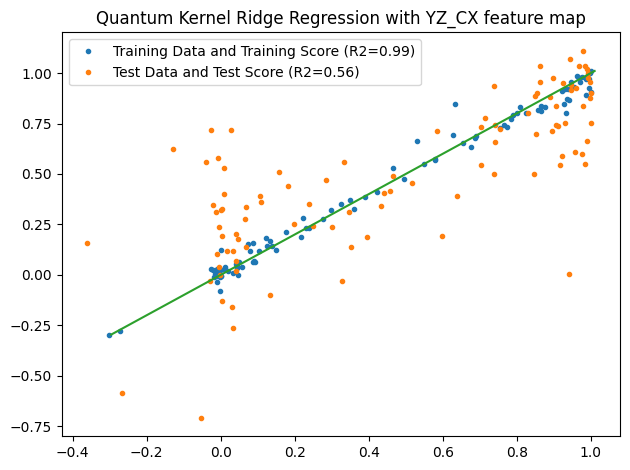

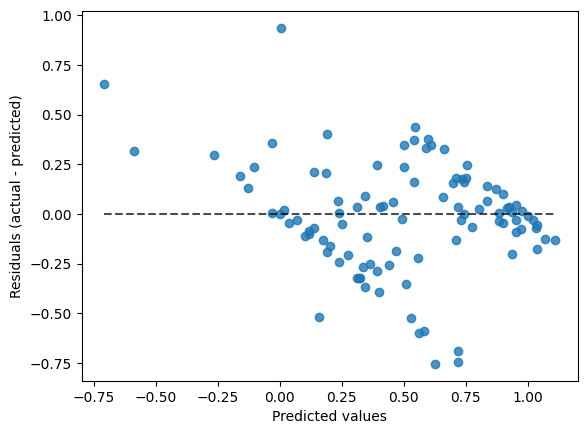

In [42]:
yz_cx_kernel = ProjectedQuantumKernel(yz_cx,Executor("statevector_simulator"),parameter_seed=0, gamma=0.4)
yz_cx_krr = QKRR(quantum_kernel=yz_cx_kernel, alpha=0.01)
yz_cx_krr.fit(X_train,Y_train)

Y1_yz_cx = yz_cx_krr.predict(X_train)
Y2_yz_cx = yz_cx_krr.predict(X_test)

training_score_yz_cx = yz_cx_krr.score(X_train,Y_train)
test_score_yz_cx = yz_cx_krr.score(X_test,Y_test)
print("TRAINING SCORE AT START:",yz_cx_krr.score(X_train,Y_train))
print("TEST SCORE AT START:",yz_cx_krr.score(X_test,Y_test))
plt.figure()
plt.title("Quantum Kernel Ridge Regression with YZ_CX feature map")
plt.plot(Y_train,Y1_yz_cx,'.', label=f"Training Data and Training Score (R2={training_score_yz_cx:.2f})")
plt.plot(Y_test,Y2_yz_cx,'.', label=f"Test Data and Test Score (R2={test_score_yz_cx:.2f})")
plt.plot([np.min(Y1_yz_cx),np.max(Y1_yz_cx)],[np.min(Y1_yz_cx),np.max(Y1_yz_cx)])
plt.legend(loc="upper left")
plt.tight_layout()
disp = PredictionErrorDisplay.from_predictions(y_true=Y_test, y_pred=Y2_yz_cx)
plt.show()

Text(0.5, 1.0, 'Generated feature map')

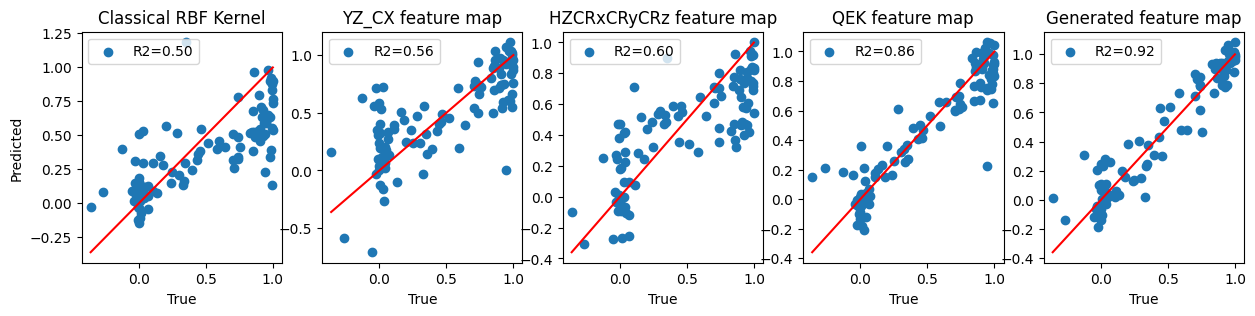

In [69]:
# create a subplot with 1 row and 5 columns
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# create a list of the models, so we can iterate through them below
models = [
    krr,
    yz_cx_krr,
    hzcrx_krr,
    qek_krr,
    q_krr,
]

# iterate through the models and draw a scatter plot
for ax, model in zip(axs, models):
    
    ax.scatter(Y_test, model.predict(X_test), label=f"R2={model.score(X_test,Y_test):.2f}")
    ax.plot([np.min(Y_test),np.max(Y_test)],[np.min(Y_test),np.max(Y_test)], color='red')
    ax.legend(loc="upper left")
    ax.set_xlabel("True")
    if ax == axs[0]:
        ax.set_ylabel("Predicted")
axs[0].set_title("Classical RBF Kernel")
axs[1].set_title("YZ_CX feature map")
axs[2].set_title("HZCRxCRyCRz feature map")
axs[3].set_title("QEK feature map")
axs[4].set_title("Generated feature map")

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {"num_qubits": [4,5,6,8], "num_layers": [1,2,3,4], "gamma": [0.1,0.2,0.3,0.4,0.5,0.6,0.7]}
qek_map = QEKFeatureMap(num_qubits=4, num_features=4, num_layers=2)
qek_kernel = ProjectedQuantumKernel(qek_map,Executor("statevector_simulator"),parameter_seed=0, gamma=0.8)
qek_krr = QKRR(quantum_kernel=qek_kernel, alpha=0.01)

grid_search = GridSearchCV(qek_krr, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)


Fitting 5 folds for each of 112 candidates, totalling 560 fits
